# Notebook 2 (Data from 30 second samples )

Project: Classification of song genre

Group Name: Prince Polo

Members: Anna Kudela, Kacper Szkudlarek, Szymon Kowaczyk


# Packs and path

In [30]:
import numpy as np
from tabulate import tabulate
import os
import csv
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

Loading data and cheaking if nulls

In [32]:
df=pd.read_csv('data_ost2s.csv')

In [33]:
print(df.isnull().values.any())

False


# Data exploration and visualization

BPM Boxplot and chosen feature histogram

In [34]:
x = df[["label", "tempo"]]

bpm_box = px.box(
    df, 
    y="tempo", 
    x="label", 
    color="label", 
    title="BPM Boxplot for Genres", 
    width=900 
)

bpm_box.show()

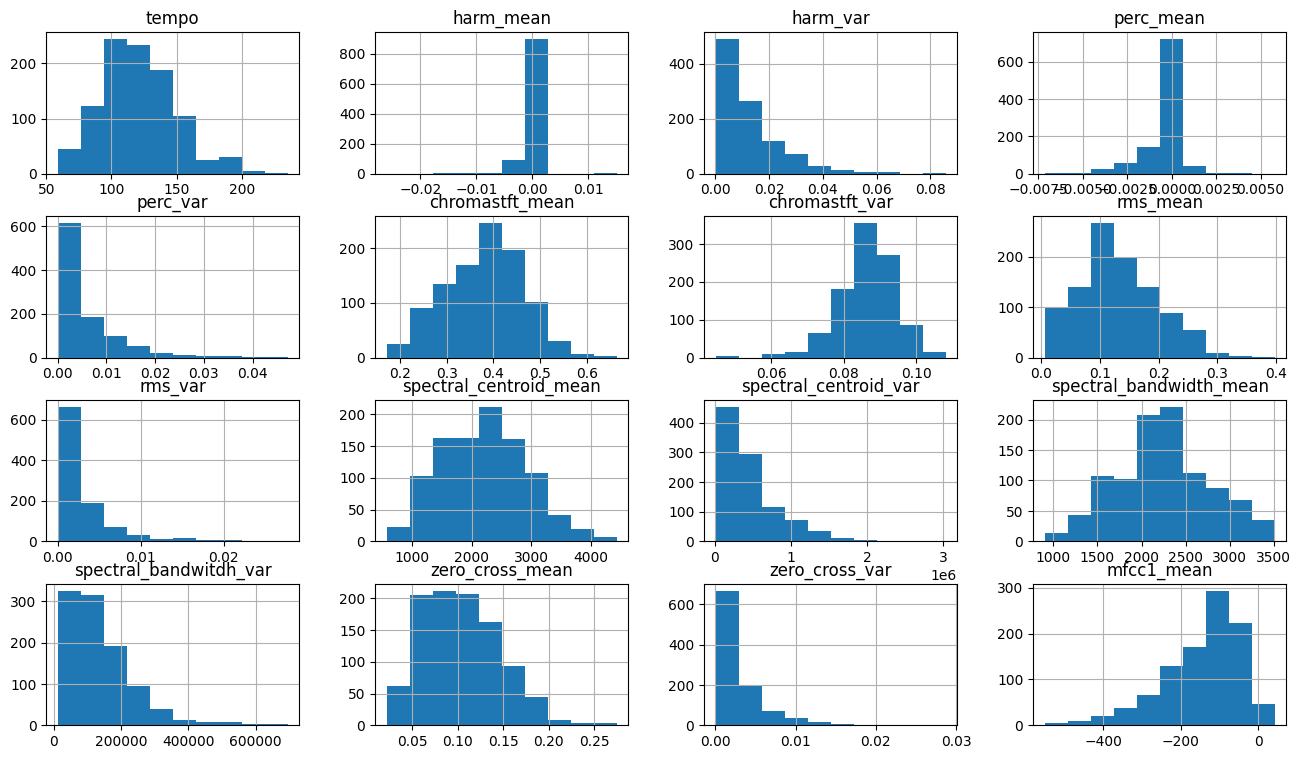

In [35]:
df.iloc[: , :17].hist( figsize=(16, 9))
plt.show()

Interactive multiplot- showing histogram of chosen feature

In [36]:
def multi_plot(df, addAll = True):
    fig = go.Figure()
    X = df.loc[:, df.columns.isin(['zero_cross_var', 'mfcc1_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc20_var', 'mfcc21_mean', 'mfcc22_var', 'mfcc23_mean', 'mfcc24_var', 'mfcc25_mean', 'mfcc26_var', 'mfcc27_mean', 'mfcc28_var', 'mfcc29_mean', 'mfcc30_var', 'mfcc31_mean', 'mfcc32_var', 'mfcc33_mean', 'mfcc34_var', 'mfcc35_mean', 'mfcc36_var', 'mfcc37_mean', 'mfcc38_var', 'mfcc39_mean', 'mfcc40_var'])]
    cols = X.columns
    for column in cols.to_list():
        fig.add_trace(
            go.Histogram(
                x = X[column]
            )
        )

    button_all = dict(label = 'all',
                      method = 'update',
                      args = [{'visible': cols,
                               'title': 'all',
                               'showlegend': False}])
    
    def create_layout_button(column):
        return dict(label = column,
                    method = 'update',
                    args = [{'visible': cols.isin([column]),
                             'title': column,
                             'showlegend': False}])
    
    fig.update_layout(
        updatemenus=[go.layout.Updatemenu(
            active = 0,
            showactive=False,
            buttons = ([button_all] * addAll) + list(cols.map(lambda column: create_layout_button(column)))
            )
        ])

    fig.show()

multi_plot(df)

Reducing the number of variables (dimensionality) of a data using PCA

In [37]:
df = df.iloc[0:, 1:]
y = df['label']
X = df.loc[:, df.columns != 'label']

cols = X.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

px.scatter(finalDf, x = "principal component 1", y = "principal component 2", color='label', title='PCA on Genres').show()

Correlation Matrix for average and variance of features

In [38]:
spike = [col for col in df.columns if 'mean' in col]
corr = df[spike].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# f, ax = plt.subplots(figsize=(16, 11));

# sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

pio.templates.default = "plotly_white"

heat = go.Heatmap(
    z=corr.mask(mask),
    x=corr.columns,
    y=corr.columns,
    colorscale=px.colors.diverging.RdBu,
    zmin=-1,
    zmax=1
)

title = 'Correlation Matrix for average of features'

layout = go.Layout(
    title_text=title, 
    title_x=0.5, 
    width=600, 
    height=600,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

go.Figure(data=[heat], layout=layout).show()

C:\Users\s1z2y\AppData\Local\Temp\ipykernel_16616\3750035649.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [39]:
spike = [col for col in df.columns if 'var' in col]
corr = df[spike].corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

heat = go.Heatmap(
    z=corr.mask(mask),
    x=corr.columns,
    y=corr.columns,
    colorscale=px.colors.diverging.RdBu[::-1],
    zmin=-1,
    zmax=1
)

title = 'Correlation Matrix for variance of features'

layout = go.Layout(
    title_text=title, 
    title_x=0.5, 
    width=600, 
    height=600,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

go.Figure(data=[heat], layout=layout).show()

C:\Users\s1z2y\AppData\Local\Temp\ipykernel_16616\3352268112.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



# Data preparation
We generate data on our own, so there is no need to cleanse or structure data. 

## Data normalization

Spliting dataset

In [40]:
df = df.iloc[0:, 1:] 
Y = df['label'] # genre variable.
X = df.loc[:, df.columns != 'label'] #select all columns but not the labels
cols = X.columns

In [41]:
def test_train_sp(X,y,size):
  return train_test_split(X, y, test_size=size, random_state=42)

Normalize so everything is on the same scale using StandardScaler and MinMaxScaler Normalization (in individual analyze we will be using only StandardScaler and set_test_size=0.2 but in combined analyze we will use and compare both normalization methods and diffrent test sizes)






In [42]:
def MinMaxScalerNorm(X):
  min_max_scaler = preprocessing.MinMaxScaler()
  np_scaled = min_max_scaler.fit_transform(X)
  return np_scaled

def StandardScalerNorm(X):
  standard_scaler = preprocessing.StandardScaler()
  np_scaled = standard_scaler.fit_transform(X)
  return np_scaled


In [43]:
X_stand = pd.DataFrame(StandardScalerNorm(X), columns = cols)
genres = list(df['label'].unique())
X_train, X_test, Y_train, Y_test = test_train_sp(X,y,0.2)

# Predicting using ML Methods
The following algorithms will be used:
-Naive Bayes 
-Stochastic Gradient Descent     
-KNN    
-Decission trees    
-Random Forest    
-Support Vector Machine    
-Logistic Regression

For each metod we calculate accuracy score, classification_report and plot confusion_matrix to explore each method separetly.

#  Predicting separetly

## Logistic Regression

accuracy score:  0.585

classification_report:
               precision    recall  f1-score   support

       blues       0.62      0.65      0.63        20
   classical       0.93      1.00      0.96        13
     country       0.63      0.63      0.63        27
       disco       0.38      0.29      0.32        21
      hiphop       0.25      0.27      0.26        15
        jazz       0.83      0.68      0.75        22
       metal       0.59      0.68      0.63        25
         pop       0.52      0.85      0.65        13
      reggae       0.71      0.65      0.68        23
        rock       0.35      0.29      0.32        21

    accuracy                           0.58       200
   macro avg       0.58      0.60      0.58       200
weighted avg       0.58      0.58      0.58       200



Text(0.5, 1.0, 'Confusion_matrix LogisticRegression')

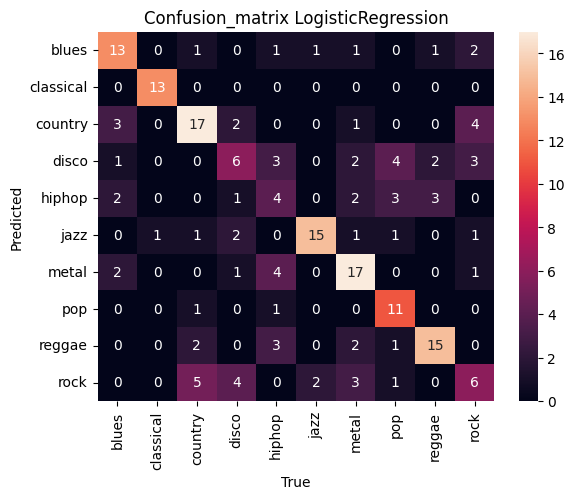

In [44]:
lr = LogisticRegression(solver = 'liblinear', multi_class='ovr')
lr.fit(X_train, Y_train)
predictions = lr.predict(X_test)

print("accuracy score: ", accuracy_score(Y_test, predictions))
print("\nclassification_report:\n", classification_report(Y_test, predictions, target_names=genres))

# true and predicted axis
cm =confusion_matrix(Y_test, predictions)  
cm_df = pd.DataFrame(cm,genres,genres)                      
ax=sns.heatmap(cm_df, annot=True)
ax.set(xlabel='True', ylabel='Predicted')
ax.set_title("Confusion_matrix LogisticRegression") 

## Naive Bayes

Accuracy score:  0.46
              precision    recall  f1-score   support

       blues       0.62      0.25      0.36        20
   classical       1.00      0.85      0.92        13
     country       0.55      0.44      0.49        27
       disco       0.26      0.48      0.33        21
      hiphop       0.50      0.20      0.29        15
        jazz       0.73      0.36      0.48        22
       metal       0.37      0.76      0.49        25
         pop       0.47      0.54      0.50        13
      reggae       0.52      0.52      0.52        23
        rock       0.38      0.24      0.29        21

    accuracy                           0.46       200
   macro avg       0.54      0.46      0.47       200
weighted avg       0.52      0.46      0.46       200



Text(0.5, 1.0, 'Confusion_matrix Naive Bayes')

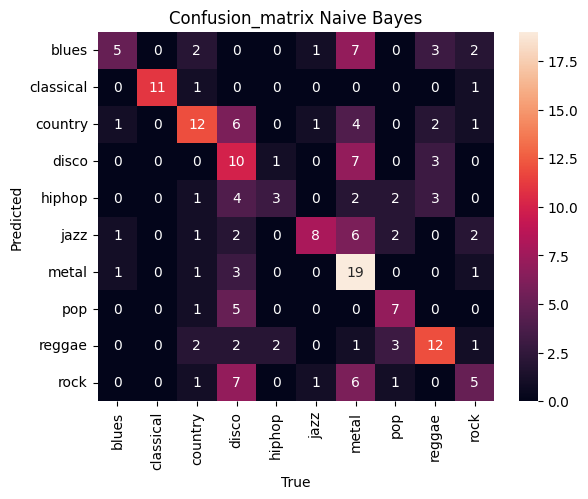

In [45]:
nb = GaussianNB()
nb.fit(X_train, Y_train)
predictions = nb.predict(X_test)
print("Accuracy score: ", accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions, target_names=genres))

cm =confusion_matrix(Y_test, predictions)  
cm_df = pd.DataFrame(cm,genres,genres)                      
ax=sns.heatmap(cm_df, annot=True)
ax.set(xlabel='True', ylabel='Predicted')
ax.set_title("Confusion_matrix Naive Bayes") 

## Stochastic Gradient Descent

accuracy score:  0.18

classification_report:
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.67      0.77      0.71        13
     country       0.00      0.00      0.00        27
       disco       0.00      0.00      0.00        21
      hiphop       0.13      0.67      0.22        15
        jazz       0.00      0.00      0.00        22
       metal       0.71      0.20      0.31        25
         pop       0.00      0.00      0.00        13
      reggae       0.11      0.48      0.18        23
        rock       0.00      0.00      0.00        21

    accuracy                           0.18       200
   macro avg       0.16      0.21      0.14       200
weighted avg       0.15      0.18      0.12       200



c:\Users\s1z2y\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\s1z2y\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\s1z2y\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(0.5, 1.0, 'Confusion_matrix Stochastic Gradient Descent')

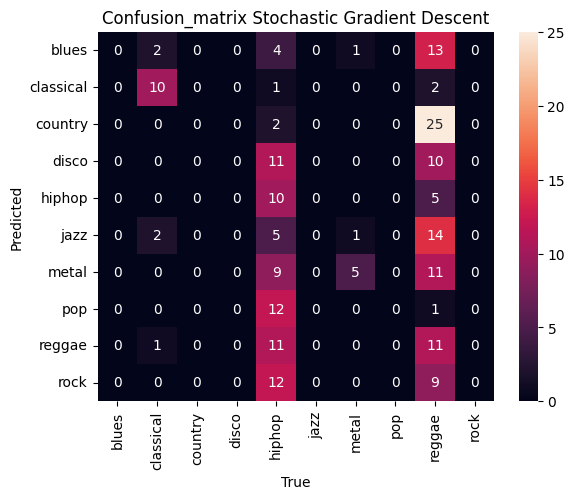

In [46]:
sgd = SGDClassifier(max_iter=5000, random_state=0)
sgd.fit(X_train, Y_train)
predictions = sgd.predict(X_test)
print("accuracy score: ", accuracy_score(Y_test, predictions))
print("\nclassification_report:\n", classification_report(Y_test, predictions, target_names=genres))

cm =confusion_matrix(Y_test, predictions)  
cm_df = pd.DataFrame(cm,genres,genres)                      
ax=sns.heatmap(cm_df, annot=True)
ax.set(xlabel='True', ylabel='Predicted')
ax.set_title("Confusion_matrix Stochastic Gradient Descent") 


From confusion matrix, we can see Stochastic Gradient Descent have a huge problem with analyzing  hip-hop and reggae.

## KNeighborsClassifier
Chosing best k neighbors in range(4,20)

In [47]:
best_acc_k=[]
for neighbor in range(5,21):
    knn=KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, Y_train)
    predictions = knn.predict(X_test)
    best_acc_k.append(accuracy_score(Y_test, predictions))


best_k=best_acc_k.index(max(best_acc_k))+4
print("Best k=",best_k)

Best k= 16


accuracy score:  0.24

classification_report:
               precision    recall  f1-score   support

       blues       0.08      0.10      0.09        20
   classical       0.45      0.69      0.55        13
     country       0.31      0.19      0.23        27
       disco       0.17      0.24      0.20        21
      hiphop       0.12      0.13      0.12        15
        jazz       0.27      0.18      0.22        22
       metal       0.29      0.24      0.26        25
         pop       0.30      0.69      0.42        13
      reggae       0.29      0.22      0.25        23
        rock       0.11      0.05      0.07        21

    accuracy                           0.24       200
   macro avg       0.24      0.27      0.24       200
weighted avg       0.24      0.24      0.23       200



Text(0.5, 1.0, 'Confusion_matrix KNeighborsClassifier')

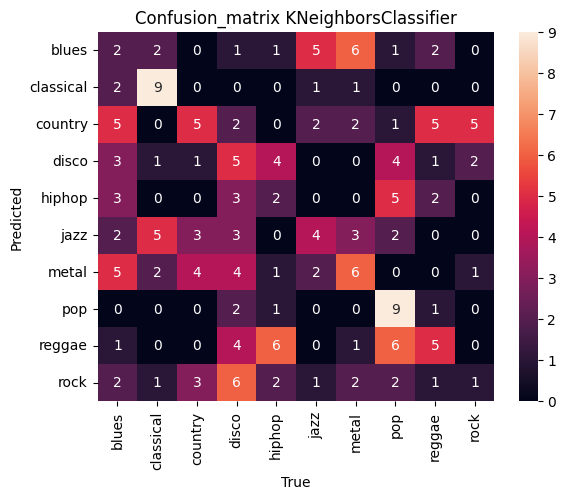

In [48]:
knn=KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, Y_train)
predictions = knn.predict(X_test)
print("accuracy score: ", accuracy_score(Y_test, predictions))
print("\nclassification_report:\n", classification_report(Y_test, predictions, target_names=genres))

cm =confusion_matrix(Y_test, predictions)  
cm_df = pd.DataFrame(cm,genres,genres)                      
ax=sns.heatmap(cm_df, annot=True)
ax.set(xlabel='True', ylabel='Predicted')
ax.set_title("Confusion_matrix KNeighborsClassifier") 


## DecisionTreeClassifier
Chosing maximum depth in range(4,30)

In [49]:
best_acc_depth=[]
for depth in range(5,31):
    dtree=DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    dtree.fit(X_train, Y_train)
    predictions = dtree.predict(X_test)
    best_acc_depth.append(accuracy_score(Y_test, predictions))


best_depth=best_acc_depth.index(max(best_acc_depth))+4
print("Best depth=",best_depth)

Best depth= 14


accuracy score:  0.535

classification_report:
               precision    recall  f1-score   support

       blues       0.54      0.70      0.61        20
   classical       0.80      0.62      0.70        13
     country       0.55      0.44      0.49        27
       disco       0.41      0.33      0.37        21
      hiphop       0.29      0.47      0.36        15
        jazz       0.52      0.64      0.57        22
       metal       0.83      0.76      0.79        25
         pop       0.60      0.69      0.64        13
      reggae       0.53      0.35      0.42        23
        rock       0.43      0.43      0.43        21

    accuracy                           0.54       200
   macro avg       0.55      0.54      0.54       200
weighted avg       0.55      0.54      0.53       200



Text(0.5, 1.0, 'Confusion_matrix DecisionTreeClassifier')

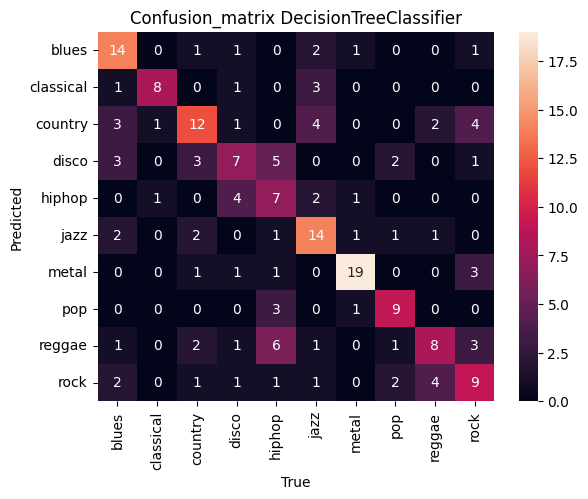

In [50]:
depth=best_depth

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
dtree.fit(X_train, Y_train)
predictions = dtree.predict(X_test)
print("accuracy score: ", accuracy_score(Y_test, predictions))
print("\nclassification_report:\n", classification_report(Y_test, predictions, target_names=genres))

cm =confusion_matrix(Y_test, predictions)  
cm_df = pd.DataFrame(cm,genres,genres)                      
ax=sns.heatmap(cm_df, annot=True)
ax.set(xlabel='True', ylabel='Predicted')
ax.set_title("Confusion_matrix DecisionTreeClassifier") 

## Random Forest

accuracy score:  0.69

classification_report:
               precision    recall  f1-score   support

       blues       0.84      0.80      0.82        20
   classical       0.92      0.92      0.92        13
     country       0.75      0.67      0.71        27
       disco       0.43      0.48      0.45        21
      hiphop       0.60      0.60      0.60        15
        jazz       0.78      0.82      0.80        22
       metal       0.84      0.84      0.84        25
         pop       0.71      0.92      0.80        13
      reggae       0.57      0.52      0.55        23
        rock       0.50      0.48      0.49        21

    accuracy                           0.69       200
   macro avg       0.69      0.70      0.70       200
weighted avg       0.69      0.69      0.69       200



Text(0.5, 1.0, 'Confusion_matrix RandomForest')

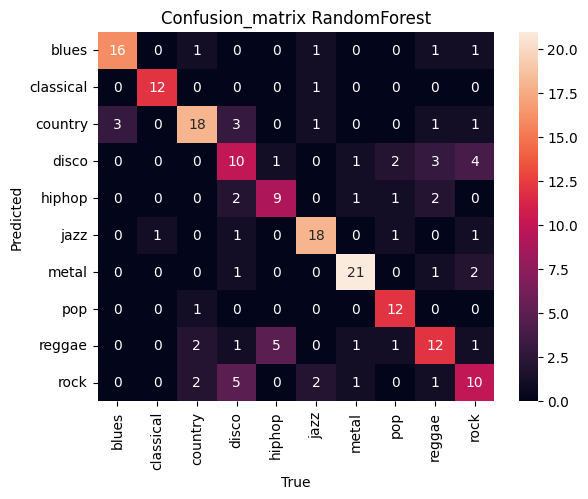

In [51]:
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
rforest.fit(X_train, Y_train)
predictions = rforest.predict(X_test)
print("accuracy score: ", accuracy_score(Y_test, predictions))
print("\nclassification_report:\n", classification_report(Y_test, predictions, target_names=genres))

cm =confusion_matrix(Y_test, predictions)  
cm_df = pd.DataFrame(cm,genres,genres)                      
ax=sns.heatmap(cm_df, annot=True)
ax.set(xlabel='True', ylabel='Predicted')
ax.set_title("Confusion_matrix RandomForest") 



## Support Vector Machine

accuracy score:  0.25

classification_report:
               precision    recall  f1-score   support

       blues       0.05      0.05      0.05        20
   classical       0.24      0.77      0.37        13
     country       0.20      0.11      0.14        27
       disco       0.26      0.52      0.34        21
      hiphop       0.00      0.00      0.00        15
        jazz       0.00      0.00      0.00        22
       metal       0.28      0.36      0.32        25
         pop       0.31      0.77      0.44        13
      reggae       0.43      0.26      0.32        23
        rock       0.00      0.00      0.00        21

    accuracy                           0.25       200
   macro avg       0.18      0.28      0.20       200
weighted avg       0.18      0.25      0.19       200



c:\Users\s1z2y\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\s1z2y\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\s1z2y\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Text(0.5, 1.0, 'Confusion_matrix Support Vector Machine')

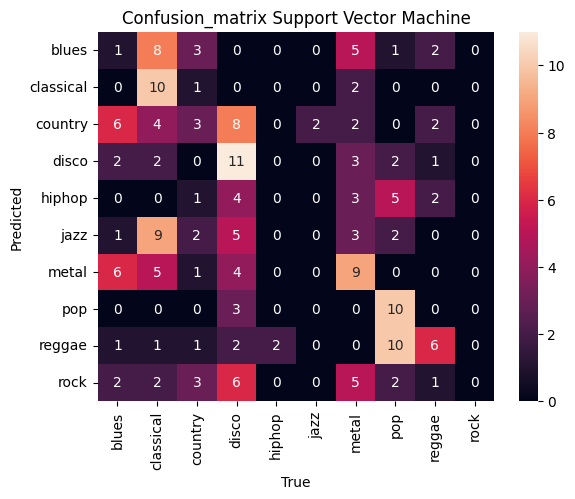

In [52]:
svm = SVC(decision_function_shape="ovo")
svm .fit(X_train, Y_train)
predictions = svm.predict(X_test)
print("accuracy score: ", accuracy_score(Y_test, predictions))
print("\nclassification_report:\n", classification_report(Y_test, predictions, target_names=genres))

cm =confusion_matrix(Y_test, predictions)  
cm_df = pd.DataFrame(cm,genres,genres)                      
ax=sns.heatmap(cm_df, annot=True)
ax.set(xlabel='True', ylabel='Predicted')
ax.set_title("Confusion_matrix Support Vector Machine") 

## Predicting Combined
We will analyze and compare all above methods for different normalization methods and  test sizes

In [53]:
def model_assess(model, genres, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return  [round(accuracy_score(y_test, preds), 5) ,title]


In [54]:
X_stand = pd.DataFrame(StandardScalerNorm(X), columns = cols)
X_minmax = pd.DataFrame(MinMaxScalerNorm(X), columns = cols)
genres = list(df['label'].unique())
data=[]
norm=['StandardScaler', 'MinMaxScaler']
for test_size in [.1,.2,.3,.4]:
  i=0
  for X in [X_stand,X_minmax]:
    X_train, X_test, y_train, y_test = test_train_sp(X,y,test_size)

    # Naive Bayes
    nb = GaussianNB()
    nb_data=model_assess(nb,list(df['label'].unique()), "Naive Bayes")

    # Stochastic Gradient Descent
    sgd = SGDClassifier(max_iter=5000, random_state=0)
    sgd_data=model_assess(sgd,list(df['label'].unique()),"Stochastic Gradient Descent")

    # KNN
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn_data=model_assess(knn,list(df['label'].unique()), "KNN")

    # Decission trees
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    tree_data=model_assess(tree,list(df['label'].unique()), "Decission trees")

    # Random Forest
    rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
    rforest_data=model_assess(rforest,list(df['label'].unique()), "Random Forest")

    # Support Vector Machine
    svm = SVC(decision_function_shape="ovo")
    svm_data=model_assess(svm,list(df['label'].unique()), "Support Vector Machine")

    # Logistic Regression
    lg = LogisticRegression(solver = 'liblinear', multi_class='ovr')
    lg_data=model_assess(lg,list(df['label'].unique()), "Logistic Regression")

    #combining data
    if i==0:
      test_size1=test_size 
    else:
      test_size1=''
    data.append([test_size1,norm[i],nb_data[0],sgd_data[0],knn_data[0],tree_data[0],rforest_data[0],svm_data[0],lg_data[0]])

    i=+1

label_data=['Test_size','Normalization',nb_data[1],sgd_data[1],knn_data[1],tree_data[1],rforest_data[1],svm_data[1],lg_data[1]]
print(tabulate(data, headers=label_data))

Test_size    Normalization      Naive Bayes    Stochastic Gradient Descent      KNN    Decission trees    Random Forest    Support Vector Machine    Logistic Regression
-----------  ---------------  -------------  -----------------------------  -------  -----------------  ---------------  ------------------------  ---------------------
0.1          StandardScaler          0.45                          0.55     0.63               0.5                 0.68                   0.66                   0.66
             MinMaxScaler            0.45                          0.58     0.61               0.52                0.68                   0.6                    0.66
0.2          StandardScaler          0.525                         0.615    0.645              0.555               0.69                   0.74                   0.7
             MinMaxScaler            0.525                         0.615    0.61               0.565               0.69                   0.645                  0.63

For best set_test_size=0.2. Classification report was calculated showing deatiles of prediction splited on genres. 

In [55]:
def model_assess(model, genres, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return  [classification_report(y_test, preds, target_names=genres) ,title]

In [56]:
# new data frame with the new scaled data. 
X_stand = pd.DataFrame(StandardScalerNorm(X), columns = cols)
X_minmax = pd.DataFrame(MinMaxScalerNorm(X), columns = cols)
genres = list(df['label'].unique())
data=[]
norm=['StandardScaler', 'MinMaxScaler']
for test_size in [.2]:
  i=0
  for X in [X_stand,X_minmax]:
    X_train, X_test, y_train, y_test = test_train_sp(X,y,test_size)
    # Naive Bayes
    nb = GaussianNB()
    nb_data=model_assess(nb,list(df['label'].unique()), "Naive Bayes")

    # Stochastic Gradient Descent
    sgd = SGDClassifier(max_iter=5000, random_state=0)
    sgd_data=model_assess(sgd,list(df['label'].unique()),"Stochastic Gradient Descent")

    # KNN
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn_data=model_assess(knn,list(df['label'].unique()), "KNN")

    # Decission trees
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    tree_data=model_assess(tree,list(df['label'].unique()), "Decission trees")

    # Random Forest
    rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
    rforest_data=model_assess(rforest,list(df['label'].unique()), "Random Forest")

    # Support Vector Machine
    svm = SVC(decision_function_shape="ovo")
    svm_data=model_assess(svm,list(df['label'].unique()), "Support Vector Machine")

    # Logistic Regression
    lg = LogisticRegression(solver = 'liblinear', multi_class='ovr')
    lg_data=model_assess(lg,list(df['label'].unique()), "Logistic Regression")

    data.append([norm[i],nb_data[0],sgd_data[0],knn_data[0],tree_data[0],rforest_data[0],svm_data[0],lg_data[0]])

    i=+1

label_data=['Normalization',nb_data[1],sgd_data[1],knn_data[1],tree_data[1],rforest_data[1],svm_data[1],lg_data[1]]
print(tabulate(data, headers=label_data))

Normalization    Naive Bayes                                            Stochastic Gradient Descent                            KNN                                                    Decission trees                                        Random Forest                                          Support Vector Machine                                 Logistic Regression
---------------  -----------------------------------------------------  -----------------------------------------------------  -----------------------------------------------------  -----------------------------------------------------  -----------------------------------------------------  -----------------------------------------------------  -----------------------------------------------------
StandardScaler   precision    recall  f1-score   support                precision    recall  f1-score   support                precision    recall  f1-score   support                precision    recall  f1-score   support           

Because big amount of data to in table it is best visible in text editor or created file

In [57]:
with open('Classification_report_summary30s.txt', 'w') as file:
    file.write(tabulate(data, headers=label_data))

# Conclusions

We observe best results for set_test_size=0.2 for every method.

Also, accuracy score for given method are very similar no matter what Scaler we chose. However, we can see that for Logistic Regression, Support Vector Machine, KNN we get better results using StandardScaler  but in some cases for Decission trees  MinMaxScaler is better.

The table below shows methods listed from the worst to the best with range of accuracy_score. From the table, we observe the worst method for our data is Naive Bayes and the best is Support Vector Machine.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">Method</th>
    <th class="tg-0lax">range of accuracy_score:</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">-Naive Bayes</td>
    <td class="tg-0lax">[0.45-0.525]</td>
  </tr>
  <tr>
    <td class="tg-0lax">-Decission trees</td>
    <td class="tg-0lax">[0.48-0.565]</td>
  </tr>
  <tr>
    <td class="tg-0lax">-Stochastic Gradient Descent</td>
    <td class="tg-0lax">[0.55-0.615]</td>
  </tr>
  <tr>
    <td class="tg-0lax">-KNN</td>
    <td class="tg-0lax">[0.565-0.645]</td>
  </tr>
  <tr>
    <td class="tg-0lax">-Logistic Regression</td>
    <td class="tg-0lax">[0.6-0.7]</td>
  </tr>
  <tr>
    <td class="tg-0lax">-Support Vector Machine</td>
    <td class="tg-0lax">[0.635-0.74]</td>
  </tr>
</tbody>
</table>

Our set is quite small (1,000 records) thus accuracy score is in range [0.45-0.67] we assume that above methods will perform better on bigger set thats why we will perform the same operations on 5 second samples (6,000 records) in Notebook3 and compare the results.